In [ ]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import cv2

In [ ]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Train Phase transformations

albu_transforms = A.Compose([ #modified this slightly
    A.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.2010)),
    A.PadIfNeeded(min_height=40, min_width=40, border_mode=cv2.BORDER_CONSTANT, value=(0, 0, 0)),  # Padding by 4
    A.RandomCrop(32, 32),  # Random Crop to 32x32
    A.HorizontalFlip(p=0.5),  # FlipLR - Horizontal flip
    A.CoarseDropout(max_holes=1, max_height=8, max_width=8, min_holes=1, min_height=8, min_width=8, fill_value=(0, 0, 0), p=0.5),  # CutOut
    ToTensorV2(),
])

def albu_transform(image):
    # Convert PIL image to numpy array
    image_np = np.array(image)
    # Apply Albumentations transforms
    transformed = albu_transforms(image=image_np)
    return transformed['image']

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
                                       ])


In [ ]:
train = datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=albu_transform)
test = datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=test_transforms)

100%|██████████| 170498071/170498071 [00:04<00:00, 39397036.30it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=512, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


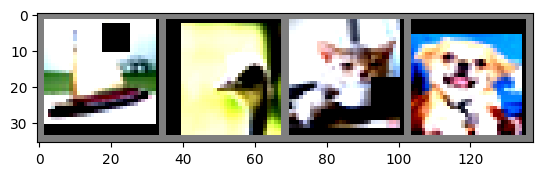

ship  bird  cat   dog  


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

import torchvision
# show images
imshow(torchvision.utils.make_grid(images[:4]))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [ ]:
# !pip install torchsummary

In [ ]:
import torch.nn.functional as F
from torchsummary import summary

class CustomResNet(nn.Module):
    def __init__(self):
        super(CustomResNet, self).__init__()

        # PrepLayer - Conv 3x3 s1, p1) >> BN >> RELU [64k]
        self.prep = nn.Sequential(
            nn.Conv2d(3, 64, 3, stride = 1, padding = 1, bias = False),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        # X = Conv 3x3 (s1, p1) >> MaxPool2D >> BN >> RELU [128k]
        self.conv1 = nn.Sequential(  #input_size = 32
            nn.Conv2d(64, 128, 3, padding=1, stride = 1, bias=False), #kernel_is: 3x3
            nn.MaxPool2d(2,2),
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )
        # R1 = ResBlock( (Conv-BN-ReLU-Conv-BN-ReLU))(X) [128k]
        self.r1 = nn.Sequential( #16
            nn.Conv2d(128, 128, 3, padding = 1, stride = 1, bias = False),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, 3, padding = 1, stride = 1, bias = False),
            nn.BatchNorm2d(128),
            nn.ReLU(),
        ) #16
        # Conv 3x3 [256k] LAYER2
        self.conv2 = nn.Sequential( #16
            nn.Conv2d(128, 256, 3, padding = 1, stride = 1, bias = False),
            nn.MaxPool2d(2,2),
            nn.BatchNorm2d(256),
            nn.ReLU(),
        ) #8
        # LAYER3 X = Conv 3x3 (s1, p1) >> MaxPool2D >> BN >> RELU [512k
        self.conv3 = nn.Sequential(
            nn.Conv2d(256, 512, 3, padding=1, stride = 1, bias=False), #kernel_is: 3x3
            nn.MaxPool2d(2,2),
            nn.BatchNorm2d(512),
            nn.ReLU(),
        ) #4
        # R2 = ResBlock( (Conv-BN-ReLU-Conv-BN-ReLU))(X) [512k]
        self.r2 = nn.Sequential(
            nn.Conv2d(512, 512, 3, padding = 1, stride = 1, bias = False),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, 3, padding = 1, stride = 1, bias = False),
            nn.BatchNorm2d(512),
            nn.ReLU(),
        )
        # self.pool1 = nn.MaxPool2d(4) Rather than implementing maxpool like this, u could do: 
        self.pool1 = nn.Sequential(nn.MaxPool2d(4,4)) #this should prolly take care of the tuple problem
        self.fc1 = nn.Linear(in_features=512, out_features=10) #cifar10, so 10
        self.gap = nn.AdaptiveAvgPool2d(1)

    def forward(self, x):
        x = self.prep(x)
        x = self.conv1(x)
        r1 = self.r1(x)
        x = x + r1
        x = self.conv2(x)
        x = self.conv3(x)
        r2 = self.r2(x)
        x = x + r2
        x = self.gap(x)
        # print("Ater pool shape, ", x.shape) #torch.Size([2, 512, 1, 1])
        x = x.view(-1, 512)
        x = self.fc1(x)
        x = x.view(-1, 10)  #this line is prolly not required
        return F.log_softmax(x, dim=-1)

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = CustomResNet().to(device)
summary(model, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 32, 32]          73,728
         MaxPool2d-5          [-1, 128, 16, 16]               0
       BatchNorm2d-6          [-1, 128, 16, 16]             256
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,456
       BatchNorm2d-9          [-1, 128, 16, 16]             256
             ReLU-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 128, 16, 16]         147,456
      BatchNorm2d-12          [-1, 128, 16, 16]             256
             ReLU-13          [-1, 128, 16, 16]               0
           Conv2d-14          [-1,

In [ ]:
from tqdm import tqdm
from torch.optim.lr_scheduler import StepLR
from torch.optim.lr_scheduler import ReduceLROnPlateau

train_losses = []
test_losses = []
train_acc = []
test_acc = []
lrs = []

def get_lr(optimizer):
  for param_group in optimizer.param_groups:
    return param_group['lr']

def train(model, device, train_loader, optimizer, epoch, scheduler, criterion): #adding scheduler and criterion
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = criterion(y_pred, target)
    train_losses.append(loss)
    lrs.append(get_lr(optimizer))                           #adding extra line

    # Backpropagation
    loss.backward()
    optimizer.step()
    scheduler.step()                                        #adding extra line

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

                                                            #adding get_lr function below
    pbar.set_description(desc= f'Loss={loss.item()} LR={get_lr(optimizer)} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader, criterion):            #added criterion here
    model.eval()
    test_loss = 0
    correct = 0
    # misclassified_images = []  # List to store misclassified images and labels
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim = True)  # Remove keepdim=True; now shape: [batch_size]
            correct += pred.eq(target.view_as(pred)).sum().item()        #modified this line

            # Find misclassified indices
            # misclassified_idxs = (pred != target).nonzero(as_tuple=False).squeeze()
            # for idx in misclassified_idxs:
            #     if len(misclassified_images) < 10:  # Collect only 10 images
            #         img = data[idx].cpu()
            #         actual_label = target[idx].item()
            #         predicted_label = pred[idx].item()
            #         misclassified_images.append((img, predicted_label, actual_label))
            #     else:
            #         break

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    Accuracy = 100. * correct / len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))
    return Accuracy

In [ ]:
!pip install torch-lr-finder

  0%|          | 0/100 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 4.04E-03


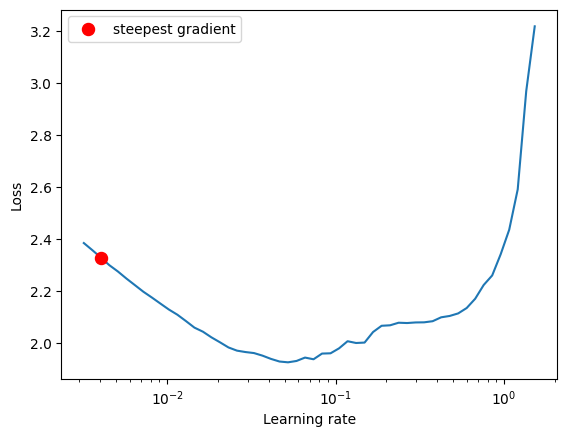

In [ ]:
#adding new code
from torch_lr_finder import LRFinder

model = CustomResNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
lr_finder.range_test(train_loader, end_lr=100, num_iter=100)
lr_finder.plot() # to inspect the loss-learning rate graph
lr_finder.reset() # this should give u the lr to feed in OneCyclePolicy

In [ ]:
from torch.optim.lr_scheduler import OneCycleLR
EPOCHS = 24
scheduler = OneCycleLR(
    optimizer, #defined above
    max_lr = 4.04E-03 , #u'll get above, 1.12E-01= 81.99%
    steps_per_epoch = len(train_loader),
    epochs = EPOCHS,
    pct_start = 5/EPOCHS,
    div_factor = 100 , #defining min_lr
    three_phase = False, #no Annihilation
    final_div_factor = 100 , #again in support of min_lr
    anneal_strategy = 'linear'
)
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch, scheduler, criterion) #adding criterion as argument
    test(model, device, test_loader, criterion)                                #modified train and test function

EPOCH: 0


Loss=1.154700756072998 LR=0.0008419558282208588 Batch_id=97 Accuracy=46.66: 100%|██████████| 98/98 [00:19<00:00,  4.92it/s]



Test set: Average loss: 0.0025, Accuracy: 5780/10000 (57.80%)

EPOCH: 1


Loss=0.8407325744628906 LR=0.0016435116564417175 Batch_id=97 Accuracy=67.30: 100%|██████████| 98/98 [00:20<00:00,  4.71it/s]



Test set: Average loss: 0.0020, Accuracy: 6711/10000 (67.11%)

EPOCH: 2


Loss=0.6240781545639038 LR=0.0024450674846625766 Batch_id=97 Accuracy=74.93: 100%|██████████| 98/98 [00:19<00:00,  5.00it/s]



Test set: Average loss: 0.0016, Accuracy: 7311/10000 (73.11%)

EPOCH: 3


Loss=0.5088396072387695 LR=0.003246623312883435 Batch_id=97 Accuracy=78.81: 100%|██████████| 98/98 [00:20<00:00,  4.89it/s]



Test set: Average loss: 0.0017, Accuracy: 7393/10000 (73.93%)

EPOCH: 4


Loss=0.6570845246315002 LR=0.0040378305069817405 Batch_id=97 Accuracy=81.10: 100%|██████████| 98/98 [00:21<00:00,  4.59it/s]



Test set: Average loss: 0.0019, Accuracy: 7252/10000 (72.52%)

EPOCH: 5


Loss=0.49102193117141724 LR=0.0038252201911922667 Batch_id=97 Accuracy=83.34: 100%|██████████| 98/98 [00:19<00:00,  4.95it/s]



Test set: Average loss: 0.0015, Accuracy: 7601/10000 (76.01%)

EPOCH: 6


Loss=0.39594390988349915 LR=0.003612609875402793 Batch_id=97 Accuracy=84.86: 100%|██████████| 98/98 [00:20<00:00,  4.76it/s]



Test set: Average loss: 0.0017, Accuracy: 7437/10000 (74.37%)

EPOCH: 7


Loss=0.36955881118774414 LR=0.003399999559613319 Batch_id=97 Accuracy=86.39: 100%|██████████| 98/98 [00:19<00:00,  4.93it/s]



Test set: Average loss: 0.0011, Accuracy: 8258/10000 (82.58%)

EPOCH: 8


Loss=0.3700406551361084 LR=0.0031873892438238453 Batch_id=97 Accuracy=87.75: 100%|██████████| 98/98 [00:26<00:00,  3.73it/s]



Test set: Average loss: 0.0012, Accuracy: 8057/10000 (80.57%)

EPOCH: 9


Loss=0.2897164523601532 LR=0.0029747789280343715 Batch_id=97 Accuracy=88.57: 100%|██████████| 98/98 [00:19<00:00,  4.95it/s]



Test set: Average loss: 0.0009, Accuracy: 8463/10000 (84.63%)

EPOCH: 10


Loss=0.2989588677883148 LR=0.0027621686122448978 Batch_id=97 Accuracy=89.88: 100%|██████████| 98/98 [00:20<00:00,  4.79it/s]



Test set: Average loss: 0.0009, Accuracy: 8597/10000 (85.97%)

EPOCH: 11


Loss=0.2628879249095917 LR=0.002549558296455424 Batch_id=97 Accuracy=90.04: 100%|██████████| 98/98 [00:19<00:00,  5.01it/s]



Test set: Average loss: 0.0008, Accuracy: 8663/10000 (86.63%)

EPOCH: 12


Loss=0.3125922679901123 LR=0.0023369479806659506 Batch_id=97 Accuracy=91.35: 100%|██████████| 98/98 [00:20<00:00,  4.75it/s]



Test set: Average loss: 0.0009, Accuracy: 8644/10000 (86.44%)

EPOCH: 13


Loss=0.259015828371048 LR=0.002124337664876477 Batch_id=97 Accuracy=91.73: 100%|██████████| 98/98 [00:19<00:00,  4.98it/s]



Test set: Average loss: 0.0009, Accuracy: 8514/10000 (85.14%)

EPOCH: 14


Loss=0.20941588282585144 LR=0.001911727349087003 Batch_id=97 Accuracy=92.18: 100%|██████████| 98/98 [00:19<00:00,  4.94it/s]



Test set: Average loss: 0.0007, Accuracy: 8852/10000 (88.52%)

EPOCH: 15


Loss=0.19234691560268402 LR=0.0016991170332975297 Batch_id=97 Accuracy=93.10: 100%|██████████| 98/98 [00:19<00:00,  5.01it/s]



Test set: Average loss: 0.0007, Accuracy: 8848/10000 (88.48%)

EPOCH: 16


Loss=0.2219029814004898 LR=0.0014865067175080559 Batch_id=97 Accuracy=93.68: 100%|██████████| 98/98 [00:19<00:00,  5.01it/s]



Test set: Average loss: 0.0008, Accuracy: 8812/10000 (88.12%)

EPOCH: 17


Loss=0.17126679420471191 LR=0.001273896401718582 Batch_id=97 Accuracy=94.49: 100%|██████████| 98/98 [00:19<00:00,  4.98it/s]



Test set: Average loss: 0.0007, Accuracy: 8996/10000 (89.96%)

EPOCH: 18


Loss=0.12851841747760773 LR=0.0010612860859291083 Batch_id=97 Accuracy=95.24: 100%|██████████| 98/98 [00:19<00:00,  5.01it/s]



Test set: Average loss: 0.0006, Accuracy: 9031/10000 (90.31%)

EPOCH: 19


Loss=0.1514618694782257 LR=0.0008486757701396345 Batch_id=97 Accuracy=95.79: 100%|██████████| 98/98 [00:19<00:00,  4.91it/s]



Test set: Average loss: 0.0006, Accuracy: 9135/10000 (91.35%)

EPOCH: 20


Loss=0.1232546716928482 LR=0.0006360654543501611 Batch_id=97 Accuracy=96.65: 100%|██████████| 98/98 [00:19<00:00,  5.00it/s]



Test set: Average loss: 0.0006, Accuracy: 9154/10000 (91.54%)

EPOCH: 21


Loss=0.05092441290616989 LR=0.00042345513856068733 Batch_id=97 Accuracy=97.32: 100%|██████████| 98/98 [00:20<00:00,  4.88it/s]



Test set: Average loss: 0.0005, Accuracy: 9230/10000 (92.30%)

EPOCH: 22


Loss=0.06490076333284378 LR=0.00021084482277121354 Batch_id=97 Accuracy=97.97: 100%|██████████| 98/98 [00:19<00:00,  5.00it/s]



Test set: Average loss: 0.0005, Accuracy: 9282/10000 (92.82%)

EPOCH: 23


Loss=0.06875644624233246 LR=-1.7654930182598241e-06 Batch_id=97 Accuracy=98.43: 100%|██████████| 98/98 [00:20<00:00,  4.86it/s]



Test set: Average loss: 0.0005, Accuracy: 9319/10000 (93.19%)



In [ ]:
model

CustomResNet(
  (prep): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (conv1): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
  )
  (r1): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
  )
  (conv2): Sequential(
    (0): Conv2d(128, 256, k

In [ ]:
t = [train_items.item() for train_items in train_losses]

Text(0.5, 1.0, 'Test Accuracy')

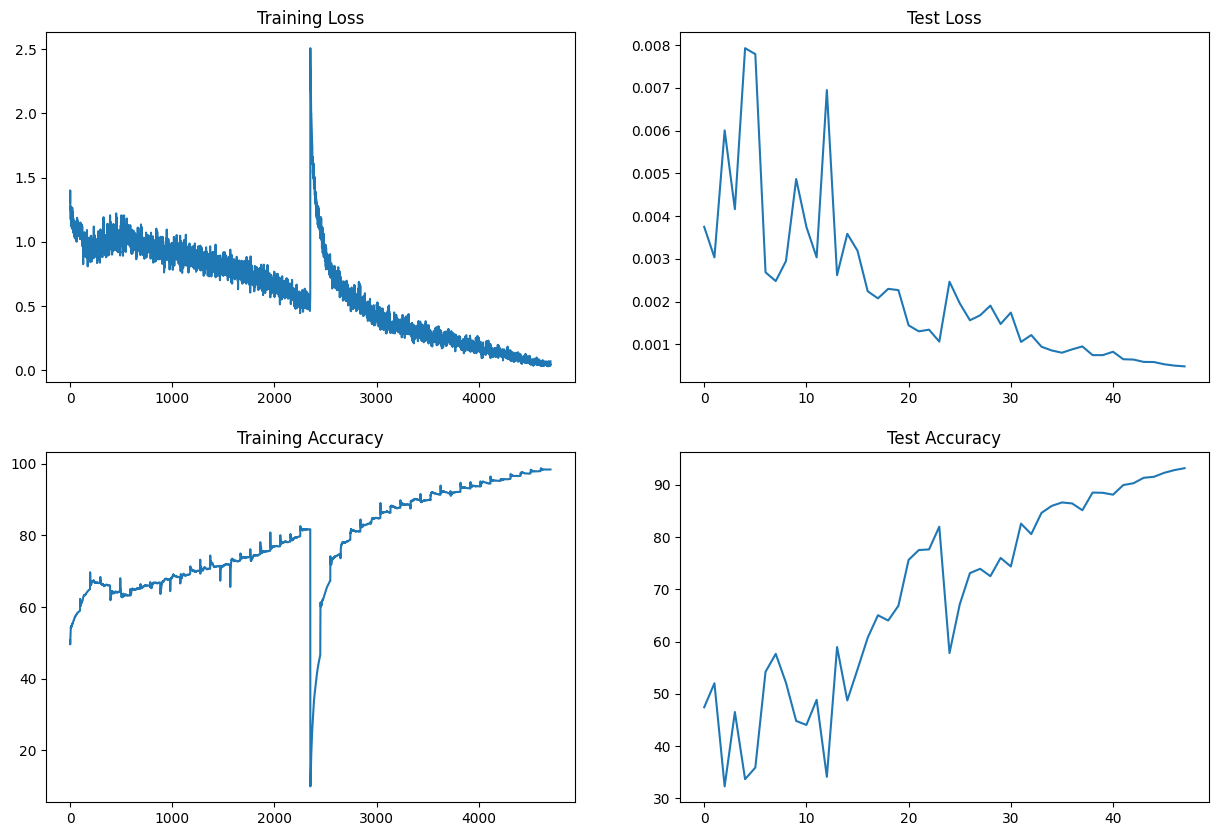

In [ ]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(t)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

Text(0, 0.5, 'Learning rate')

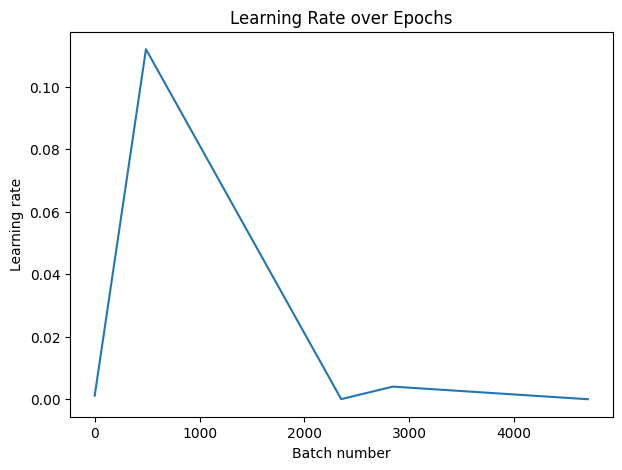

In [ ]:
# Additional Plot for Learning Rates
fig, ax_lr = plt.subplots(figsize=(7, 5))
ax_lr.plot(lrs)
ax_lr.set_title("Learning Rate over Epochs")
ax_lr.set_xlabel("Batch number")
ax_lr.set_ylabel("Learning rate")

# Implementing using modular code

In [2]:
from transforms import albu_transform, test_transforms
from train import train, test
from mdoel import CustomResNet
from dataloader import train_loader, test_loader
import torch

SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

CUDA Available? True


In [3]:
!pip install torch_lr_finder

In [6]:
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = CustomResNet().to(device)
summary(model, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 32, 32]          73,728
         MaxPool2d-5          [-1, 128, 16, 16]               0
       BatchNorm2d-6          [-1, 128, 16, 16]             256
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,456
       BatchNorm2d-9          [-1, 128, 16, 16]             256
             ReLU-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 128, 16, 16]         147,456
      BatchNorm2d-12          [-1, 128, 16, 16]             256
             ReLU-13          [-1, 128, 16, 16]               0
           Conv2d-14          [-1,

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


  0%|          | 0/100 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 3.59E-03


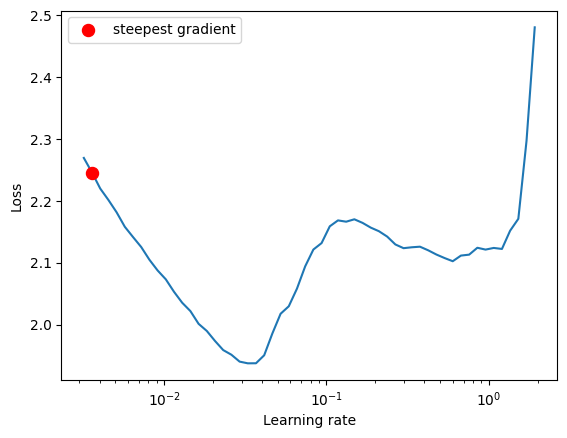

In [9]:
from torch_lr_finder import LRFinder
import torch.nn as nn
import torch.optim as optim

model = CustomResNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
lr_finder.range_test(train_loader, end_lr=100, num_iter=100)
lr_finder.plot() # to inspect the loss-learning rate graph
lr_finder.reset()

In [10]:
from torch.optim.lr_scheduler import OneCycleLR
EPOCHS = 24
scheduler = OneCycleLR(
    optimizer, #defined above
    max_lr = 4.04E-03 , #u'll get above, 1.12E-01= 81.99%
    steps_per_epoch = len(train_loader),
    epochs = EPOCHS,
    pct_start = 5/EPOCHS,
    div_factor = 100 , #defining min_lr
    three_phase = False, #no Annihilation
    final_div_factor = 100 , #again in support of min_lr
    anneal_strategy = 'linear'
)
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch, scheduler, criterion) #adding criterion as argument
    test(model, device, test_loader, criterion)                                #modified train and test function

EPOCH: 0


Loss=1.1112245321273804 LR=0.0008419558282208588 Batch_id=97 Accuracy=47.13: 100%|██████████| 98/98 [00:19<00:00,  4.97it/s]



Test set: Average loss: 0.0027, Accuracy: 5560/10000 (55.60%)

EPOCH: 1


Loss=0.9721111059188843 LR=0.0010627926380368097 Batch_id=26 Accuracy=62.69:  28%|██▊       | 27/98 [00:06<00:16,  4.37it/s]


KeyboardInterrupt: 